In [1]:
import matplotlib

In [2]:
matplotlib.use('Agg')

In [3]:
%matplotlib inline

In [1]:
import collections

In [2]:
import csv

In [3]:
import itertools

In [4]:
import numpy as np

In [4]:
import os

In [6]:
import scipy.special

In [7]:
import scipy.stats as stats

In [8]:
from statsmodels.sandbox.stats.multicomp import fdrcorrection0

In [9]:
from sklearn import metrics

---

In [10]:
os.chdir('/work/jyoung')

In [11]:
import pyuserfcn

In [5]:
os.chdir('/work/jyoung/genetic_interact/src')

In [13]:
import func_net_pred

---

**2015 September 9**

Start with *Saccharomyces cerevisiae*. For predictive seed sets (0.8 &le; AUC < 1.0), examine all possible pairs and count the number of genetic interactions between them. Execute for each type of genetic interaction. Seed sets are from BIOGRID v3.4.127 with all interactions before 2007 removed. 

**2015 September 10, 14**

It is not feasible to only examine all of the counts. There are 240 seed gene sets with 0.8 &le; AUC < 1.0, which yields 28680 total pairs - far too many to examine one-by-one. Try using a binomial distribution to calculate the significance of interaction between seed sets. Suppose the number of genes in the 1<sup>st</sup> seed set is *n*<sub>1</sub>, the number of genes in the 2<sup>nd</sup> seed set is n<sub>2</sub>, and the number of interactions between the sets is *k*. The question is what to use for the probability *p* of a "success." Should it be 1 divided by the total number of all interacting pairs? The overall total number of pairs that were tested is not known, so it is not possible to calculate the number of interacting pairs divided by the number tested. Could the number of genes in the interaction set choose 2 be used instead? 

In [14]:
experimentSys = 'Dosage Growth Defect'

In [15]:
node2edgewt = func_net_pred.process_func_net()
gene2idx = func_net_pred.assign_gene_indices(node2edgewt)

In [16]:
matrixPath = '/work/jyoung/genetic_interact/data/YeastNet2_adj_matrix.npy'
adjMat = np.load(matrixPath)

In [13]:
len(gene2idx.keys())  # number of genes in functional net

5483

In [17]:
seedSets = func_net_pred.read_biogrid(experimentSys)

Number of genes in interactions: 1192


Find number of BIOGRID interacting pairs:

In [18]:
biogridInteracts = set()
for seed in seedSets.keys():
    for interactor in seedSets[seed]:
        biogridInteracts.update([(seed, interactor), (interactor, seed)])

In [29]:
len(biogridInteracts)  # number of interacting pairs in BIOGRID

3712

In [19]:
seedAUC, seed2interactors = func_net_pred.seed_set_predictability(gene2idx, adjMat, seedSets)

Now it is possible to find the number of interacting pairs where both genes are in network:

In [20]:
inNetwkInteracts = set()
for seed in seed2interactors.keys():
    for interactor in seed2interactors[seed]:
        inNetwkInteracts.update([(seed, interactor), (interactor, seed)])

In [21]:
len(inNetwkInteracts)

3130

Create a list containing predictive seed genes.

In [22]:
lowerAUC = 0.8
upperAUC = 1.0

In [23]:
predictiveSeeds = list()
for p in seedAUC:  # p=(AUC, gene)
    if p[0] >= lowerAUC and p[0] < upperAUC:
        predictiveSeeds.append(p[1])

In [23]:
len(predictiveSeeds)

240

How many interacting pairs are there for predictive seeds?

In [21]:
interactPairs = set()
for seed in predictiveSeeds:
    for interactor in seed2interactors[seed]:
        interactPairs.update([(seed, interactor), (interactor, seed)])

In [19]:
len(interactPairs)  # number of interacting pairs (for predictive seed)

1624

Compute statistics for each pair of interactor sets. Try a binomial distributed null model. 

**2015 September 14**

The question of what the probability *p* of a "success" should be is not clear. The total number of genes among all interacting pairs could be used, but this might be overly conservative. 

In [24]:
numGenes = len(set(itertools.chain.from_iterable(inNetwkInteracts)))
print('Number of genes in network among all interactions:', numGenes)
p = len(inNetwkInteracts)/scipy.special.binom(numGenes, 2)
results = list()
for seedPair in itertools.combinations(predictiveSeeds, 2):  # seedPair=(seed1, seed2)
    interactionCount = 0
    num1stSet = len(seed2interactors[seedPair[0]])
    num2ndSet = len(seed2interactors[seedPair[1]])
    for genePair in itertools.product(seed2interactors[seedPair[0]], seed2interactors[seedPair[1]]):
        if genePair in inNetwkInteracts:
            interactionCount += 1
    n = num1stSet * num2ndSet
    pval = stats.binom.pmf(interactionCount, n, p) + stats.binom.sf(interactionCount, n, p)
    results.append((num1stSet, num2ndSet, interactionCount, pval))

Number of genes in network among all interactions: 1001


In [25]:
len(results)

28680

Is there any statistical significance at some FDR level? Try using Benjamini-Hochberg to control FDR at 5%. 

In [26]:
pvals = [x[3] for x in results]

In [27]:
rejected, pvalsCor = fdrcorrection0(pvals)

In [28]:
np.sum(rejected)

3794

Create directory to store text files in CSV format containing results.

    cd /work/jyoung/genetic_interact/results
    mkdir YeastInteractClust

In [33]:
os.chdir('/work/jyoung/genetic_interact/results/YeastInteractClust')

In [34]:
with open(''.join(experimentSys.split()) + 'Stats.txt', 'w', newline='') as csvfile:
    csvwriter = csv.writer(csvfile)
    csvwriter.writerow(['# genes in 1st set', '# genes in 2nd set', '# interactions btw sets', 'p-value'])
    for t in results:
        csvwriter.writerow(t)

**2015 September 10-11, 13-14**

Put the code above into a script so that results can be easily output for a given species and genetic interaction type. 

**2015 September 21**

It is important to note that the seed sets need to be carefully combined. For example, one seed set could be {a, b, c} and another could be {a, b, c, d}. The seed sets will be combined based on their overlap measured by the Jaccard index. The algorithm for combining them will start by considering all possible pairs of sets. If the intersection of each pair is greater than or equal to the Jaccard index, then a new set is formed by the union of the pair. Otherwise, the two sets in the pair are retained. Any set that was involved in a union is removed (unless one was a subset of the other). Now we have a new collection of sets, and the process of comparing pairs of these sets is repeated. The algorithm ends when no further unions are made. 

A script named *combining_sets_test.py* was written to test this algorithm. 

**2015 September 26**

Modify *clust_intact.py* to utilize the approach in *combining_sets_test.py* to combine the sets of genetic interactors. 

**2015 September 30**

Finished 1<sup>st</sup> working draft of *clust_intact.py* and began gathering results. "Synthetic Lethality" is taking an extremely long time to run... Noticed on October 3 that it finished running, so runtime was ~72 hrs.

**2015 October 1-2**

Adding code to *clust_intact.py* to write out input file for network visualization. *clust_intact.py* for synthetic lethality is still running, so a copy of it (with the added code) named *clust_intact_2.py* was created. A first look at the network for dosage rescue was visualized. *clust_intact_2.py* is intended to be temporary and will be subsumed by *clust_intact.py* once/if it finishes running for synthetic lethality. 

**2015 October 5-6**

*clust_intact_2.py* was re-named (and overwrote) *clust_intact.py*, which now contains code to plot networks. Currently, the networks are being examined for correctness and are used to see if the code is doing what it is intended to. Efforts to visualize the network using D3.js are on-hold, as NetworkX is currently sufficient. 

**2015 October 7**

Consider the following network:

Number of genes in functional network: 5483 

Number of predictive seed genes: 170 

The minimum Jaccard index is 0.5 

Number of set pairs: 8778 

Number of significant interacting pairs (5% FDR): 98 


The genes in the 1st cluster are:
frozenset({'RPL37A', 'UTP9', 'RPL6A', 'RPL35A', 'RPL17A', 'RPS1B', 'RPL41A', 'LSG1', 'SSF2', 'RPL11A', 'RPL43A', 'RPS26A', 'NOC3', 'RPL16B', 'RPS8A', 'PPS1', 'RPL42A', 'ARC1', 'RPS6A', 'RLP7', 'YVH1'})

The genes in the 2nd cluster are:
frozenset({'TCP1', 'CCT6', 'RPL12B', 'CCT2', 'CCT4', 'MRT4', 'CCT3'})


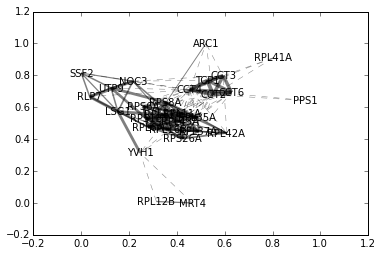

In [6]:
%run clust_intact 'Dosage Rescue' 'yeast'

Here, the genetic interaction type is dosage rescue for *S. cerevisiae*. The lower limit of predictability for seed gene sets is set to AUC = 0.9. The network shown has the most significant number of genetic interactions between two gene sets. Each gene set was formed from combining seed sets based on the Jaccard index. 

Clearly, the genes RPL41A and PPS1 have no functional partners. At first glance, this might indicate a coding error, but it turns out that there is no error. For a seed set to be predictive, not all of its members need to have high LLS sums although most of them should. RPL41A and PPS1 have LLS sums of 0.0 (their interactor is CCT4) and the rest of the genes in the set have relatively high ranks and LLS sums. The relevant code snippet for checking this is:

    argSortedSums = np.argsort(llsSum)[::-1]
    for g in seedSets[seedGene]:
        rank = np.where(argSortedSums == gene2idx[g])[0][0]
        score = llsSum[gene2idx[g]]
        print('The rank of', g, 'is', rank, 'with LLS sum', score)